## Exploring a public Web server log dataset using Apache Spark

## Part 2: Using SparkSQL and data frames to look into the data.

This notebook uses the Parquet data store created previously [[here]](https://github.com/sgcom/spark-web-log-analysis/blob/master/UofS_Logs_1_ETL.ipynb). 

#### Dataset source: http://ita.ee.lbl.gov/html/contrib/Sask-HTTP.html, available from [The Internet Traffic Archive](http://ita.ee.lbl.gov/index.html).

#### Dataset description:

This trace contains seven months’ worth of all HTTP requests to the University of Saskatchewan's WWW server. The University of Saskatchewan is located in Saskatoon, Saskatchewan, Canada.

The log contains over **_2,400,000_** lines from **_June to December 1995_** - the early days of the World Wide Web.

##### *Note: Requires Spark 1.5*

### Initialize the Apache Spark context ; check out the Spark version and config.

In [1]:
## Initialize
#
import findspark
import os
findspark.init()

import pyspark
sc = pyspark.SparkContext()

In [2]:
# Check the Spark context & config
#
# sc.version, sc._conf.getAll()

### Python imports and global settings

In [3]:
import re
import math
import time, datetime
import os
import operator as op
from pyspark import *
from pyspark.sql import Row, SQLContext
from pyspark.sql.functions import *
import matplotlib
import matplotlib.pyplot as plt

outputDir = './output'
%precision 2
%matplotlib inline

### Helpers

In [4]:
import csv

def write_to_csv( file_name, header, values_list ):
    csv_file = os.path.join(outputDir, file_name)
    with open(csv_file, 'wb') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow(header)
        for v in values_list:
            csvwriter.writerow(v)
            
week_day_map = { 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun' }

### Read from the Parquet store and register table

In [5]:
sqlContext = SQLContext(sc)
weblogDf = sqlContext.read.parquet("data/UofS_access_log.parquet")
weblogDf.registerTempTable("weblog");
weblogDf.printSchema()

root
 |-- date_time: timestamp (nullable = true)
 |-- epo_seconds: double (nullable = true)
 |-- http_status: long (nullable = true)
 |-- http_verb: string (nullable = true)
 |-- remote_host: string (nullable = true)
 |-- resp_size: long (nullable = true)
 |-- url: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- week_day: long (nullable = true)



#### Count of records - dataframe version.

In [6]:
% time weblogDf.count()

CPU times: user 978 µs, sys: 186 µs, total: 1.16 ms
Wall time: 1.01 s


2408580

#### Count of records - SQL version.

In [7]:
%time sqlContext.sql("SELECT COUNT(*) AS count FROM weblog").show()

+-------+
|  count|
+-------+
|2408580|
+-------+

CPU times: user 303 µs, sys: 1.13 ms, total: 1.44 ms
Wall time: 370 ms


#### Find all distinct URLs accessed from IP 128.95.226.85. In this case it happens to be only one unique endpoint. Using dataframe.

In [8]:
## find all distinct URLs accessed from IP 128.95.226.85
## using dataframe
#
%time weblogDf.filter(weblogDf['remote_host']=='128.95.226.85').select(['url']).distinct().show()

# in this case it happens to be only one

+-----------------+
|              url|
+-----------------+
|/images/human.gif|
+-----------------+

CPU times: user 3.66 ms, sys: 86 µs, total: 3.74 ms
Wall time: 1.69 s


#### Number of hits by HTTP Status for the full date range. Using dataframe.

In [9]:
## Number of hits by HTTP Status for the full date range
#
# Order by count
%time weblogDf.groupBy(weblogDf.http_status).count().orderBy(desc('count')).show()
# Order by status
%time weblogDf.groupBy(weblogDf.http_status).count().orderBy('http_status').show()

+-----------+-------+
|http_status|  count|
+-----------+-------+
|        200|2193512|
|        304| 151634|
|        302|  40716|
|        404|  20963|
|        400|    693|
|        500|    538|
|        403|    406|
|        401|     98|
|        501|     20|
+-----------+-------+

CPU times: user 3.98 ms, sys: 1.39 ms, total: 5.36 ms
Wall time: 1.7 s
+-----------+-------+
|http_status|  count|
+-----------+-------+
|        200|2193512|
|        302|  40716|
|        304| 151634|
|        400|    693|
|        401|     98|
|        403|    406|
|        404|  20963|
|        500|    538|
|        501|     20|
+-----------+-------+

CPU times: user 3.03 ms, sys: 173 µs, total: 3.21 ms
Wall time: 866 ms


#### Number of hits by HTTP Status for the full date range. 

+-----------+-------+
|http_status|    cnt|
+-----------+-------+
|        200|2193512|
|        302|  40716|
|        304| 151634|
|        400|    693|
|        401|     98|
|        403|    406|
|        404|  20963|
|        500|    538|
|        501|     20|
+-----------+-------+



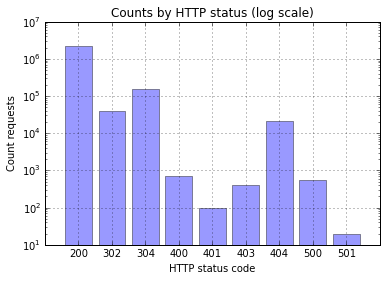

In [10]:
## Total number of hits by HTTP Status - same as the data frame version above, now with SQL
#
#  same as:  weblogDf.groupBy(weblogDf.http_status).count().orderBy('http_status').show()
#
hpsDf = sqlContext.sql(
    "SELECT http_status, COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY http_status "
    " ORDER BY http_status ")

## show the result in text format
#
hpsDf.show()

## Visualize using bar plot
#
collection = hpsDf.collect()
xv = [x.http_status for x in collection]
yv = [x.cnt for x in collection]
xseq = range(0,len(xv))
xlab = [str(x.http_status) for x in collection]
#
plt.bar(xseq, yv, align='center', alpha=0.4, log=True)
plt.xticks(xseq, xlab)
plt.grid(True)
plt.title('Counts by HTTP status (log scale)')
plt.xlabel('HTTP status code')
plt.ylabel('Count requests')
plt.show()

#### Number of hits by HTTP status code per day

In [11]:
## HTTP status by day
#
sqlContext.sql(
    "SELECT to_date(date_time) date, http_status status, COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY to_date(date_time), http_status "
    " ORDER BY date, status "
    "").show(10)

+----------+------+----+
|      date|status| cnt|
+----------+------+----+
|1995-06-01|   200|5205|
|1995-06-01|   302| 120|
|1995-06-01|   304| 233|
|1995-06-01|   400|   1|
|1995-06-01|   404|  30|
|1995-06-02|   200|6799|
|1995-06-02|   302| 140|
|1995-06-02|   304| 243|
|1995-06-02|   404|  37|
|1995-06-03|   200|3747|
+----------+------+----+
only showing top 10 rows



#### Histogram count HTTP requuests per day

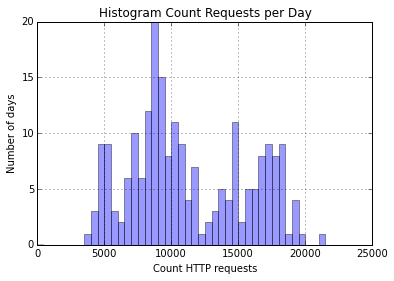

In [12]:
result = sqlContext.sql(
    "SELECT COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY to_date(date_time) "
    "").collect()

counts = [x.cnt for x in result]

plt.hist(counts, bins=range(0,25000, 500), alpha=0.4)
plt.xlabel('Count HTTP requests')
plt.ylabel('Number of days')
plt.title('Histogram Count Requests per Day')
plt.grid(True)
plt.show()

#### Histogram count HTTP requuests per remote host

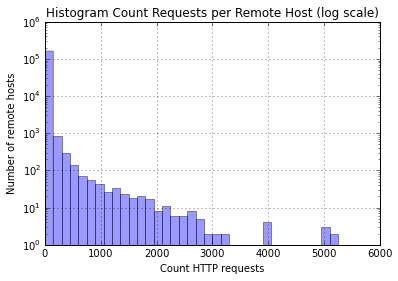

In [13]:
result = sqlContext.sql(
    "SELECT COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY remote_host "
    "").collect()

counts = [x.cnt for x in result]
#print counts
plt.hist(counts, bins=range(0,5500,150), alpha=0.4, log=True)
plt.xlabel('Count HTTP requests')
plt.ylabel('Number of remote hosts')
plt.title('Histogram Count Requests per Remote Host (log scale)')
plt.grid(True)
plt.show()

The histogram above shows a few outliers with unusually high counts. Out of curiosity, let's find them.

In [14]:
sqlContext.sql(
    "SELECT remote_host, COUNT(*) cnt "
    "  FROM weblog "
    " GROUP BY remote_host "
    " HAVING cnt > 3500 "
    " ORDER BY cnt DESC "
    "").show(50, truncate=False)

+----------------------------+-----+
|remote_host                 |cnt  |
+----------------------------+-----+
|duke.usask.ca               |52695|
|freenet.buffalo.edu         |29185|
|sask.usask.ca               |27150|
|broadway.sfn.saskatoon.sk.ca|20954|
|moondog.usask.ca            |12980|
|srv1.freenet.calgary.ab.ca  |11857|
|ccn.cs.dal.ca               |10771|
|hist6629.usask.ca           |8463 |
|scooter.pa-x.dec.com        |7948 |
|skynet.usask.ca             |7860 |
|cwis.usask.ca               |7091 |
|netinfo.ubc.ca              |6371 |
|herald.usask.ca             |6211 |
|sendit.sendit.nodak.edu     |5893 |
|abyss.usask.ca              |5291 |
|poppy.hensa.ac.uk           |5181 |
|freenet3.carleton.ca        |5165 |
|www.gnofn.org               |5038 |
|explorer.sasknet.sk.ca      |4988 |
|geol39.usask.ca             |4960 |
|interchg.ubc.ca             |4670 |
|alf.usask.ca                |4503 |
|muskat.usask.ca             |4008 |
|crimpshrine.atext.com       |3957 |
|

#### Top 10 dates with largest number of 404 errors

In [15]:
## Days with most 404 errors
#
sqlContext.sql(
    "SELECT to_date(date_time) date, week_day dow, COUNT(*) cnt "
    "  FROM weblog "
    " WHERE http_status = 404 "
    " GROUP BY to_date(date_time), week_day "
    " ORDER BY cnt DESC "
    "" ).show(10)

+----------+---+---+
|      date|dow|cnt|
+----------+---+---+
|1995-11-13|  1|416|
|1995-11-22|  3|344|
|1995-10-23|  1|342|
|1995-10-26|  4|293|
|1995-11-17|  5|288|
|1995-10-10|  2|281|
|1995-11-06|  1|270|
|1995-11-29|  3|265|
|1995-12-31|  7|263|
|1995-11-20|  1|261|
+----------+---+---+
only showing top 10 rows



#### Top 10 URLs (endpoints) with largest number of 404 errors per URL.

In [16]:
## URLs (endpoints) with most 404 errors
#
sqlContext.sql(
    "SELECT url, COUNT(*) cnt "
    "  FROM weblog "
    " WHERE http_status = 404 "
    " GROUP BY url "
    " ORDER BY cnt DESC "
    "").show(10, truncate=False)

+------------------------------------------------------------------------------------------+----+
|url                                                                                       |cnt |
+------------------------------------------------------------------------------------------+----+
|/images/logi.gif                                                                          |1831|
|/images/logo_32.gif;bytes=104-                                                            |791 |
|/images/human.gif                                                                         |652 |
|/psychiatry/ADDCentre.gif                                                                 |615 |
|/people.shtml                                                                             |312 |
|/agriculture/cropsci/winter_wheat/imgs/green.jpg                                          |296 |
|/images/logo.gif;bytes=225-                                                               |266 |
|/Canadiana         

#### Total number of HTTP requests by week day. Week strarts with Monday (1) and ends with Sunday (7).

In [17]:
## Total number of hits by day of week
#
hpwd = weblogDf.groupBy(weblogDf.week_day).count().orderBy('week_day')
hpwd.show()

+--------+------+
|week_day| count|
+--------+------+
|       1|365650|
|       2|393913|
|       3|399665|
|       4|406376|
|       5|373535|
|       6|231013|
|       7|238428|
+--------+------+



##### Visualize the total number of hits by day of week

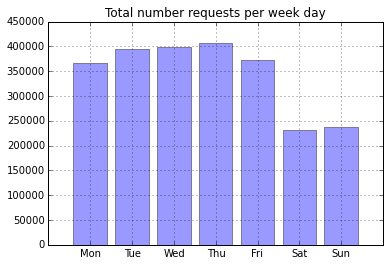

In [18]:
hpwdc = hpwd.collect()
v_week_day = map(lambda x: x[0], hpwdc)
v_cnt_hits = map(lambda x: x[1], hpwdc)
v_week_day_ab = map(lambda x: week_day_map[x[0]], hpwdc)

plt.bar(v_week_day, v_cnt_hits, align='center', alpha=0.4)
plt.xticks(v_week_day, v_week_day_ab)
plt.grid(True)
plt.title('Total number requests per week day')
plt.show()

#### Average number of hits (HTTP requests) by day of week Monday - Sunday.

In [19]:
q = ("SELECT  wday, round(hits_cnt/weeks_cnt, 1) AS avrg_hpd "
       "FROM ( "
             "SELECT week_day AS wday, COUNT(*) AS hits_cnt, COUNT(DISTINCT(to_date(date_time))) AS weeks_cnt "
             "  FROM weblog "
             " GROUP BY week_day "
             ") t2 "
     "ORDER BY wday "
     )

avg_hits_by_wday = sqlContext.sql(q)
avg_hits_by_wday.show()

+----+--------+
|wday|avrg_hpd|
+----+--------+
|   1| 12188.3|
|   2| 13130.4|
|   3| 13322.2|
|   4| 13108.9|
|   5| 12049.5|
|   6|  7452.0|
|   7|  7691.2|
+----+--------+



##### Visualize the average number of hits by day of week

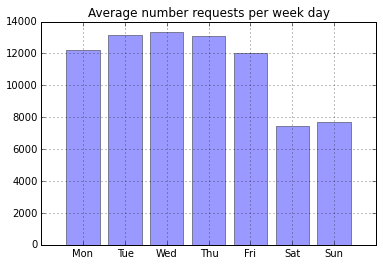

In [20]:
avg_hits_by_wday_c = avg_hits_by_wday.collect()
v_week_day = map(lambda x: x[0], avg_hits_by_wday_c)
v_cnt_hits = map(lambda x: x[1], avg_hits_by_wday_c)
v_week_day_ab = map(lambda x: week_day_map[x[0]], avg_hits_by_wday_c)

plt.bar(v_week_day, v_cnt_hits, align='center', alpha=0.4)
plt.xticks(v_week_day, v_week_day_ab)
plt.grid(True)
plt.title('Average number requests per week day')
plt.show()

#### Average count of requests per day by remote host (for the days a host was active). 

In [21]:
## Average count of hits per day for each remote host 
## (for the days a host was active) by remote host. Using sub-query.
#
q = ("SELECT  host, round(hits_cnt/days_cnt, 1) AS avrg_hpd "
       "FROM ( "
             "SELECT remote_host AS host, COUNT(*) AS hits_cnt, COUNT(DISTINCT(to_date(date_time))) AS days_cnt "
             "  FROM weblog "
             " GROUP BY remote_host "
             ") t2 "
     "ORDER BY avrg_hpd DESC "
     )

hpd_host = sqlContext.sql(q)
hpd_host.show(10, truncate=False)
hpd_host_c = hpd_host.collect()

+---------------------------+--------+
|host                       |avrg_hpd|
+---------------------------+--------+
|164.86.39.39               |255.0   |
|br-b122-38.sheridanc.on.ca |249.0   |
|duke.usask.ca              |246.2   |
|acairsid.uwyo.edu          |228.0   |
|canwebcrawler.sasknet.sk.ca|222.7   |
|199.199.207.101            |218.0   |
|ns.wcsr.com                |217.0   |
|monzapc2.it.net            |210.0   |
|p226513.sel2265.uic.edu    |179.0   |
|skynet.usask.ca            |178.6   |
+---------------------------+--------+
only showing top 10 rows



#### Write the above result to CSV, and check out a few numbers. 

In [22]:
## write to CSV
#
write_to_csv('cnt_hits_per_day_by_host.csv', ['host', 'avrg_hpd'], hpd_host_c)

## Check out a few results
#
print 'Number distinct hosts: ', len(hpd_host_c)
hpd_host_c[0], hpd_host_c[1], hpd_host_c[999], hpd_host_c[9999]

Number distinct hosts:  162512


(Row(host=u'164.86.39.39', avrg_hpd=255.0),
 Row(host=u'br-b122-38.sheridanc.on.ca', avrg_hpd=249.0),
 Row(host=u'204.191.243.2', avrg_hpd=39.0),
 Row(host=u'slip35.vaxxine.com', avrg_hpd=15.0))

#### Count of requests per day and number distinct hosts per day for November and December 

In [23]:
## Count of requests per day and distinct hosts per day for November and December
#
q = ("SELECT to_date(date_time) date, week_day, COUNT(*) cnt_hits, COUNT(DISTINCT(remote_host)) cnt_hosts "
     "  FROM weblog "
     " WHERE month(date_time) IN (11,12) "
     " GROUP BY to_date(date_time), week_day "
     " ORDER BY date" 
    )

novdec = sqlContext.sql(q)
novdec_c = novdec.collect()
novdec.show(10)

+----------+--------+--------+---------+
|      date|week_day|cnt_hits|cnt_hosts|
+----------+--------+--------+---------+
|1995-11-01|       3|   17021|     2419|
|1995-11-02|       4|   17523|     2377|
|1995-11-03|       5|   17430|     2232|
|1995-11-04|       6|   10267|     1467|
|1995-11-05|       7|   10393|     1473|
|1995-11-06|       1|   17446|     2313|
|1995-11-07|       2|   21166|     2512|
|1995-11-08|       3|   18178|     2372|
|1995-11-09|       4|   19906|     2265|
|1995-11-10|       5|   13776|     1876|
+----------+--------+--------+---------+
only showing top 10 rows



##### Save to CSV and visualize the result

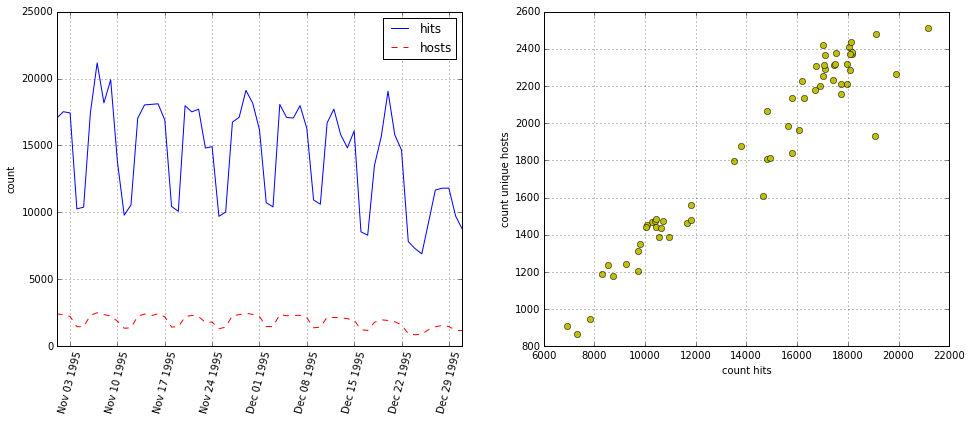

In [24]:
## Save to CSV and plot result
#

result2 = map(
    lambda x: ['%4d-%02d-%02d' % 
               (x.date.year, x.date.month, x.date.day), 
               week_day_map[x.week_day], 
               x.cnt_hits, 
               x.cnt_hosts], 
    novdec_c)

write_to_csv('cnt_requests_per_day_nov_dec.csv', ['date', 'week_day', 'cnt_hits', 'cnt_hosts'], result2)

v_date     = map(lambda x: datetime.date(x[0].year, x[0].month, x[0].day), novdec_c)
v_cnt_hits = map(lambda x: x[2], novdec_c)
v_cnt_hosts= map(lambda x: x[3], novdec_c)

fig1 = plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(v_date,v_cnt_hits,'b-',label='hits')
plt.plot(v_date,v_cnt_hosts,'r--',label='hosts')
plt.xticks(rotation=75)
plt.grid(True)
plt.legend(loc='upper right')
plt.ylabel('count')
plt.subplot(1,2,2)
plt.plot(v_cnt_hits, v_cnt_hosts, 'yo')
plt.grid(True)
plt.xlabel('count hits')
plt.ylabel('count unique hosts')
plt.show()

 * The first plot visualizes how the traffic changes over time. It is higher on business days and drops on weekends. Then it tends to drop even more during the holiday season in the end of December.
 * The second plot illustrates the relationship between total number of requests and count distinct hosts for the same period of time. Visually it appears to be very close to linear.

#### Active hosts

Suppose we are interested in the most active hosts.
There could be different definitions of "active host".
Here we are selecting hosts that have been online at least 25 different days.
Then we are registering a temporary table with columns host name (or IP) and number distinct days the host was active.

In [25]:
q = ("SELECT remote_host, COUNT(DISTINCT(to_date(date_time))) AS cnt "
     "  FROM weblog "
     " GROUP BY remote_host "
     "HAVING cnt >= 25 "
     " ORDER BY cnt DESC "
     )
hostMultiDayDf = sqlContext.sql(q)
hostMultiDayDf.registerTempTable('multi_day_hosts')
hostMultiDayDf.printSchema()

root
 |-- remote_host: string (nullable = true)
 |-- cnt: long (nullable = false)



#### Count of active hosts

In [26]:
sqlContext.sql("SELECT count(*) cnt FROM multi_day_hosts").show()

+----+
| cnt|
+----+
|1426|
+----+



#### The 10 most active hosts by number of days online

In [27]:
## The 10 most active hosts by number of days online
#
res = sqlContext.sql(
    "SELECT * "
      "FROM multi_day_hosts "
    " ORDER BY cnt DESC "
    "").show(10, truncate=False)

+----------------------------+---+
|remote_host                 |cnt|
+----------------------------+---+
|duke.usask.ca               |214|
|broadway.sfn.saskatoon.sk.ca|214|
|srv1.freenet.calgary.ab.ca  |214|
|sask.usask.ca               |214|
|moondog.usask.ca            |214|
|freenet3.carleton.ca        |212|
|ccn.cs.dal.ca               |210|
|freenet.buffalo.edu         |210|
|freenet2.carleton.ca        |210|
|scn.org                     |208|
+----------------------------+---+
only showing top 10 rows



#### Accessed URLs by host and date-time of access for the "active" hosts.

Now we will join the two tables to select the sequence of URLs the ative hosts have accessed. We want them sorted by host and date-time of access. Showing the first 10 results.

In [28]:
q = ("SELECT w.remote_host, w.date_time, w.url "
     "  FROM  weblog w JOIN multi_day_hosts m ON w.remote_host=m.remote_host "
     " ORDER BY w.remote_host, w.date_time "
     )
result = sqlContext.sql(q)
print 'count:', result.count()
result.show(20, truncate=False)

count: 991399
+--------------+---------------------+-----------------------+
|remote_host   |date_time            |url                    |
+--------------+---------------------+-----------------------+
|128.233.10.226|1995-10-24 17:52:37.0|/                      |
|128.233.10.226|1995-10-24 17:52:38.0|/images/logo.gif       |
|128.233.10.226|1995-10-24 17:53:29.0|/                      |
|128.233.10.226|1995-10-24 17:53:31.0|/images/logo.gif       |
|128.233.10.226|1995-10-24 18:03:49.0|/                      |
|128.233.10.226|1995-10-24 18:03:53.0|/images/logo.gif       |
|128.233.10.226|1995-10-24 18:29:24.0|/                      |
|128.233.10.226|1995-10-24 18:29:27.0|/images/logo.gif       |
|128.233.10.226|1995-10-25 11:13:26.0|/                      |
|128.233.10.226|1995-10-25 11:13:31.0|/images/logo.gif       |
|128.233.10.226|1995-10-25 11:15:02.0|/search.html           |
|128.233.10.226|1995-10-25 16:35:44.0|/                      |
|128.233.10.226|1995-10-25 16:35:47.0|/im

#### How many unique (distinct) URLs (endpoints) have been accessed in total? 

In fact, the number below includes also counts for same URL with distinct parameters. It does not mean that there are that many unique "pages".

In [29]:
q = ("SELECT COUNT(DISTINCT(url)) AS cnt_uniq_url "
     "  FROM weblog "
     )
sqlContext.sql(q).show()

+------------+
|cnt_uniq_url|
+------------+
|       36522|
+------------+



#### The top 20 hosts by number of unuque URLs accessed for the full period of 7 months. Uniqueness is defined same way as above - considering URL + parameters.

In [30]:
q = ("SELECT remote_host, COUNT(DISTINCT(url)) AS cnt_uniq_url "
     "  FROM weblog "
     " GROUP BY remote_host "
     " ORDER BY cnt_uniq_url DESC "
     )
sqlContext.sql(q).show(20, truncate=False)


+----------------------------+------------+
|remote_host                 |cnt_uniq_url|
+----------------------------+------------+
|scooter.pa-x.dec.com        |3938        |
|duke.usask.ca               |3390        |
|cwis.usask.ca               |2233        |
|access.usask.ca             |1472        |
|sask.usask.ca               |1286        |
|skynet.usask.ca             |1106        |
|crimpshrine.atext.com       |1070        |
|broadway.sfn.saskatoon.sk.ca|935         |
|herald.usask.ca             |826         |
|imhotep.usask.ca            |821         |
|explorer.sasknet.sk.ca      |781         |
|alf.usask.ca                |773         |
|grapes.usask.ca             |769         |
|muskat.usask.ca             |732         |
|204.62.245.32               |674         |
|mac40212.usask.ca           |659         |
|poppy.hensa.ac.uk           |652         |
|moondog.usask.ca            |612         |
|skorpio3.usask.ca           |606         |
|webgate1.mot.com            |58

---